**NAMA: Khairy Zhafhran H. Kastella**

**NIM: 202210370311439**

In [1]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split

# =========================
# 1. LOAD DATA
# =========================
labels, texts = [], []

with open("/content/spam.csv", encoding="latin-1") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        parts = line.split(";", 1)
        if len(parts) == 2:
            label, text = parts
            if label in ["ham", "spam"]:
                labels.append(0 if label == "ham" else 1)
                texts.append(text)

df = pd.DataFrame({"text": texts, "label": labels})
print(f"Total data: {len(df)}")

# =========================
# 2. SPLIT DATA
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

# =========================
# 3. TOKENIZER
# =========================
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

class SpamDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            padding=True,
            max_length=128
        )
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SpamDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# =========================
# 4. MODEL
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# =========================
# 5. TRAINING
# =========================
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

# =========================
# 6. SAVE MODEL (PASTI ADA)
# =========================
SAVE_DIR = "model_distilbert"
os.makedirs(SAVE_DIR, exist_ok=True)

model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print(f"\n✅ MODEL DISTILBERT BERHASIL DISIMPAN DI: {SAVE_DIR}/")


Total data: 5558


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.0787
Epoch 2/3 | Loss: 0.0262
Epoch 3/3 | Loss: 0.0164

✅ MODEL DISTILBERT BERHASIL DISIMPAN DI: model_distilbert/



=== CLASSIFICATION REPORT (DISTILBERT) ===
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       963
        Spam       0.96      0.95      0.96       149

    accuracy                           0.99      1112
   macro avg       0.98      0.97      0.97      1112
weighted avg       0.99      0.99      0.99      1112



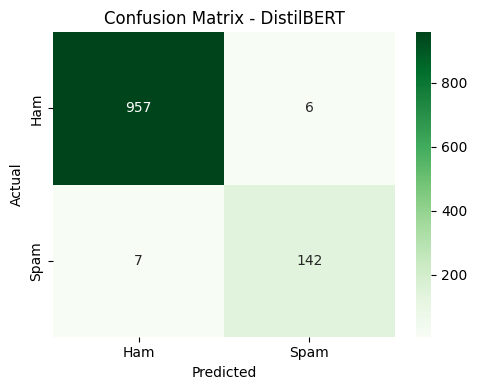

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader

# =========================
# LOAD DATA
# =========================
labels, texts = [], []

with open("/content/spam.csv", encoding="latin-1") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        parts = line.split(";", 1)
        if len(parts) == 2:
            label, text = parts
            if label in ["ham", "spam"]:
                labels.append(0 if label == "ham" else 1)
                texts.append(text)

df = pd.DataFrame({"text": texts, "label": labels})

X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

# =========================
# TOKENIZER & MODEL
# =========================
tokenizer = DistilBertTokenizerFast.from_pretrained("model_distilbert")
model = DistilBertForSequenceClassification.from_pretrained("model_distilbert")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

class SpamDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            padding=True,
            max_length=128
        )
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

test_dataset = SpamDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8)

# =========================
# PREDICTION
# =========================
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        labels = batch.pop("labels")
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# =========================
# CLASSIFICATION REPORT
# =========================
print("\n=== CLASSIFICATION REPORT (DISTILBERT) ===")
print(classification_report(
    y_true,
    y_pred,
    target_names=["Ham", "Spam"]
))

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Ham", "Spam"],
    yticklabels=["Ham", "Spam"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DistilBERT")
plt.tight_layout()
plt.show()

In [9]:
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score


In [10]:
class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            padding=True,
            max_length=max_len
        )
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


In [11]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

train_dataset = SpamDataset(X_train, y_train, tokenizer)
test_dataset  = SpamDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
EPOCHS = 5
train_losses, train_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    print(
        f"Epoch {epoch+1} | "
        f"Loss: {train_losses[-1]:.4f} | "
        f"Acc: {train_accs[-1]:.4f}"
    )


Epoch 1 | Loss: 0.0755 | Acc: 0.9748
Epoch 2 | Loss: 0.0256 | Acc: 0.9942
Epoch 3 | Loss: 0.0168 | Acc: 0.9957
Epoch 4 | Loss: 0.0068 | Acc: 0.9989
Epoch 5 | Loss: 0.0018 | Acc: 0.9998


In [15]:
os.makedirs("model_distilbert", exist_ok=True)
model.save_pretrained("model_distilbert")
tokenizer.save_pretrained("model_distilbert")


('model_distilbert/tokenizer_config.json',
 'model_distilbert/special_tokens_map.json',
 'model_distilbert/vocab.txt',
 'model_distilbert/added_tokens.json',
 'model_distilbert/tokenizer.json')

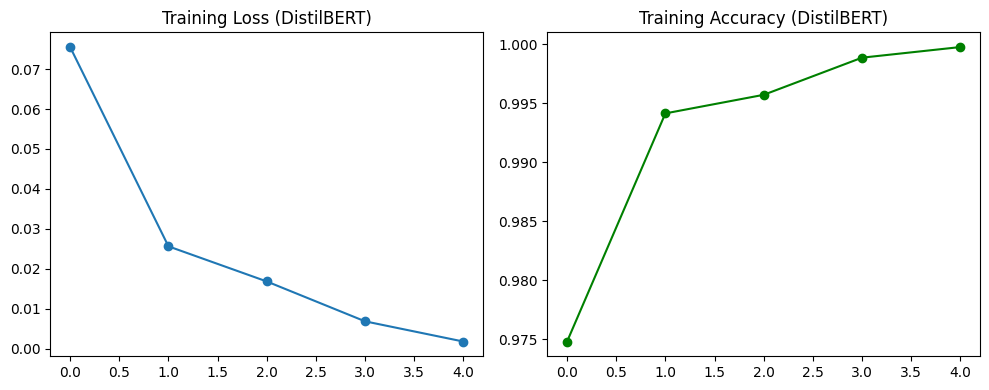

In [16]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss (DistilBERT)")

plt.subplot(1,2,2)
plt.plot(train_accs, marker='o', color='green')
plt.title("Training Accuracy (DistilBERT)")

plt.tight_layout()
plt.show()
